In [31]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
import pandas as pd
import networkx as nx
import numpy as np
import sys
import seaborn as sns

In [32]:
results_folder = 'mmvec_major_taxa_1'
results_base_name = 'latent_dim_3_input_prior_100.00_output_prior_100.00_beta1_0.90_beta2_0.95'

# Input data

In [33]:
table = pd.read_table(results_folder + '/' + results_base_name + '_ranks.txt', index_col=0)
table.head()

,Propionibacteriaceae,Staphylococcus caprae or capitis,Staphylococcus epidermidis,Staphylococcus hominis,Other Staphylococci,Polyomavirus HPyV6,Polyomavirus HPyV7,Merkel Cell Polyomavirus,Malasseziaceae,Corynebacteriaceae,Micrococcaceae,Other families
featureid,,,,,,,,,,,,
X940001,0.132622,0.037183,0.027894,-0.009730,0.102426,0.047040,-0.011837,0.057623,-0.022055,0.289731,-0.029739,0.029262
X940002,0.009868,-0.141074,-0.230662,-0.009366,-0.034335,-0.059276,-0.211371,-0.191059,-0.022357,-0.055170,-0.174999,-0.115651
X940005,-0.030528,-0.210616,-0.303804,-0.267200,0.075248,0.403110,-0.085631,-0.097856,0.010325,-0.105834,-0.142799,-0.061524
X940007,0.376647,0.238295,0.173235,0.489016,0.246871,0.021521,0.071722,0.109581,0.298914,0.321009,0.159340,0.205600
X940010,0.335391,-0.064717,0.740097,0.534891,0.330852,0.472360,0.542093,0.516329,0.158614,0.384168,0.469211,0.540476


Read microbiome metadata: Not needed as the taxon names are the column headers

Read metabolite metadata: Not needed as we are working with molecular families

# Check stats

There seams to be a local minimum of the model fit where all metabolites have (nearly) identical log conditional probabilities for every microbe.

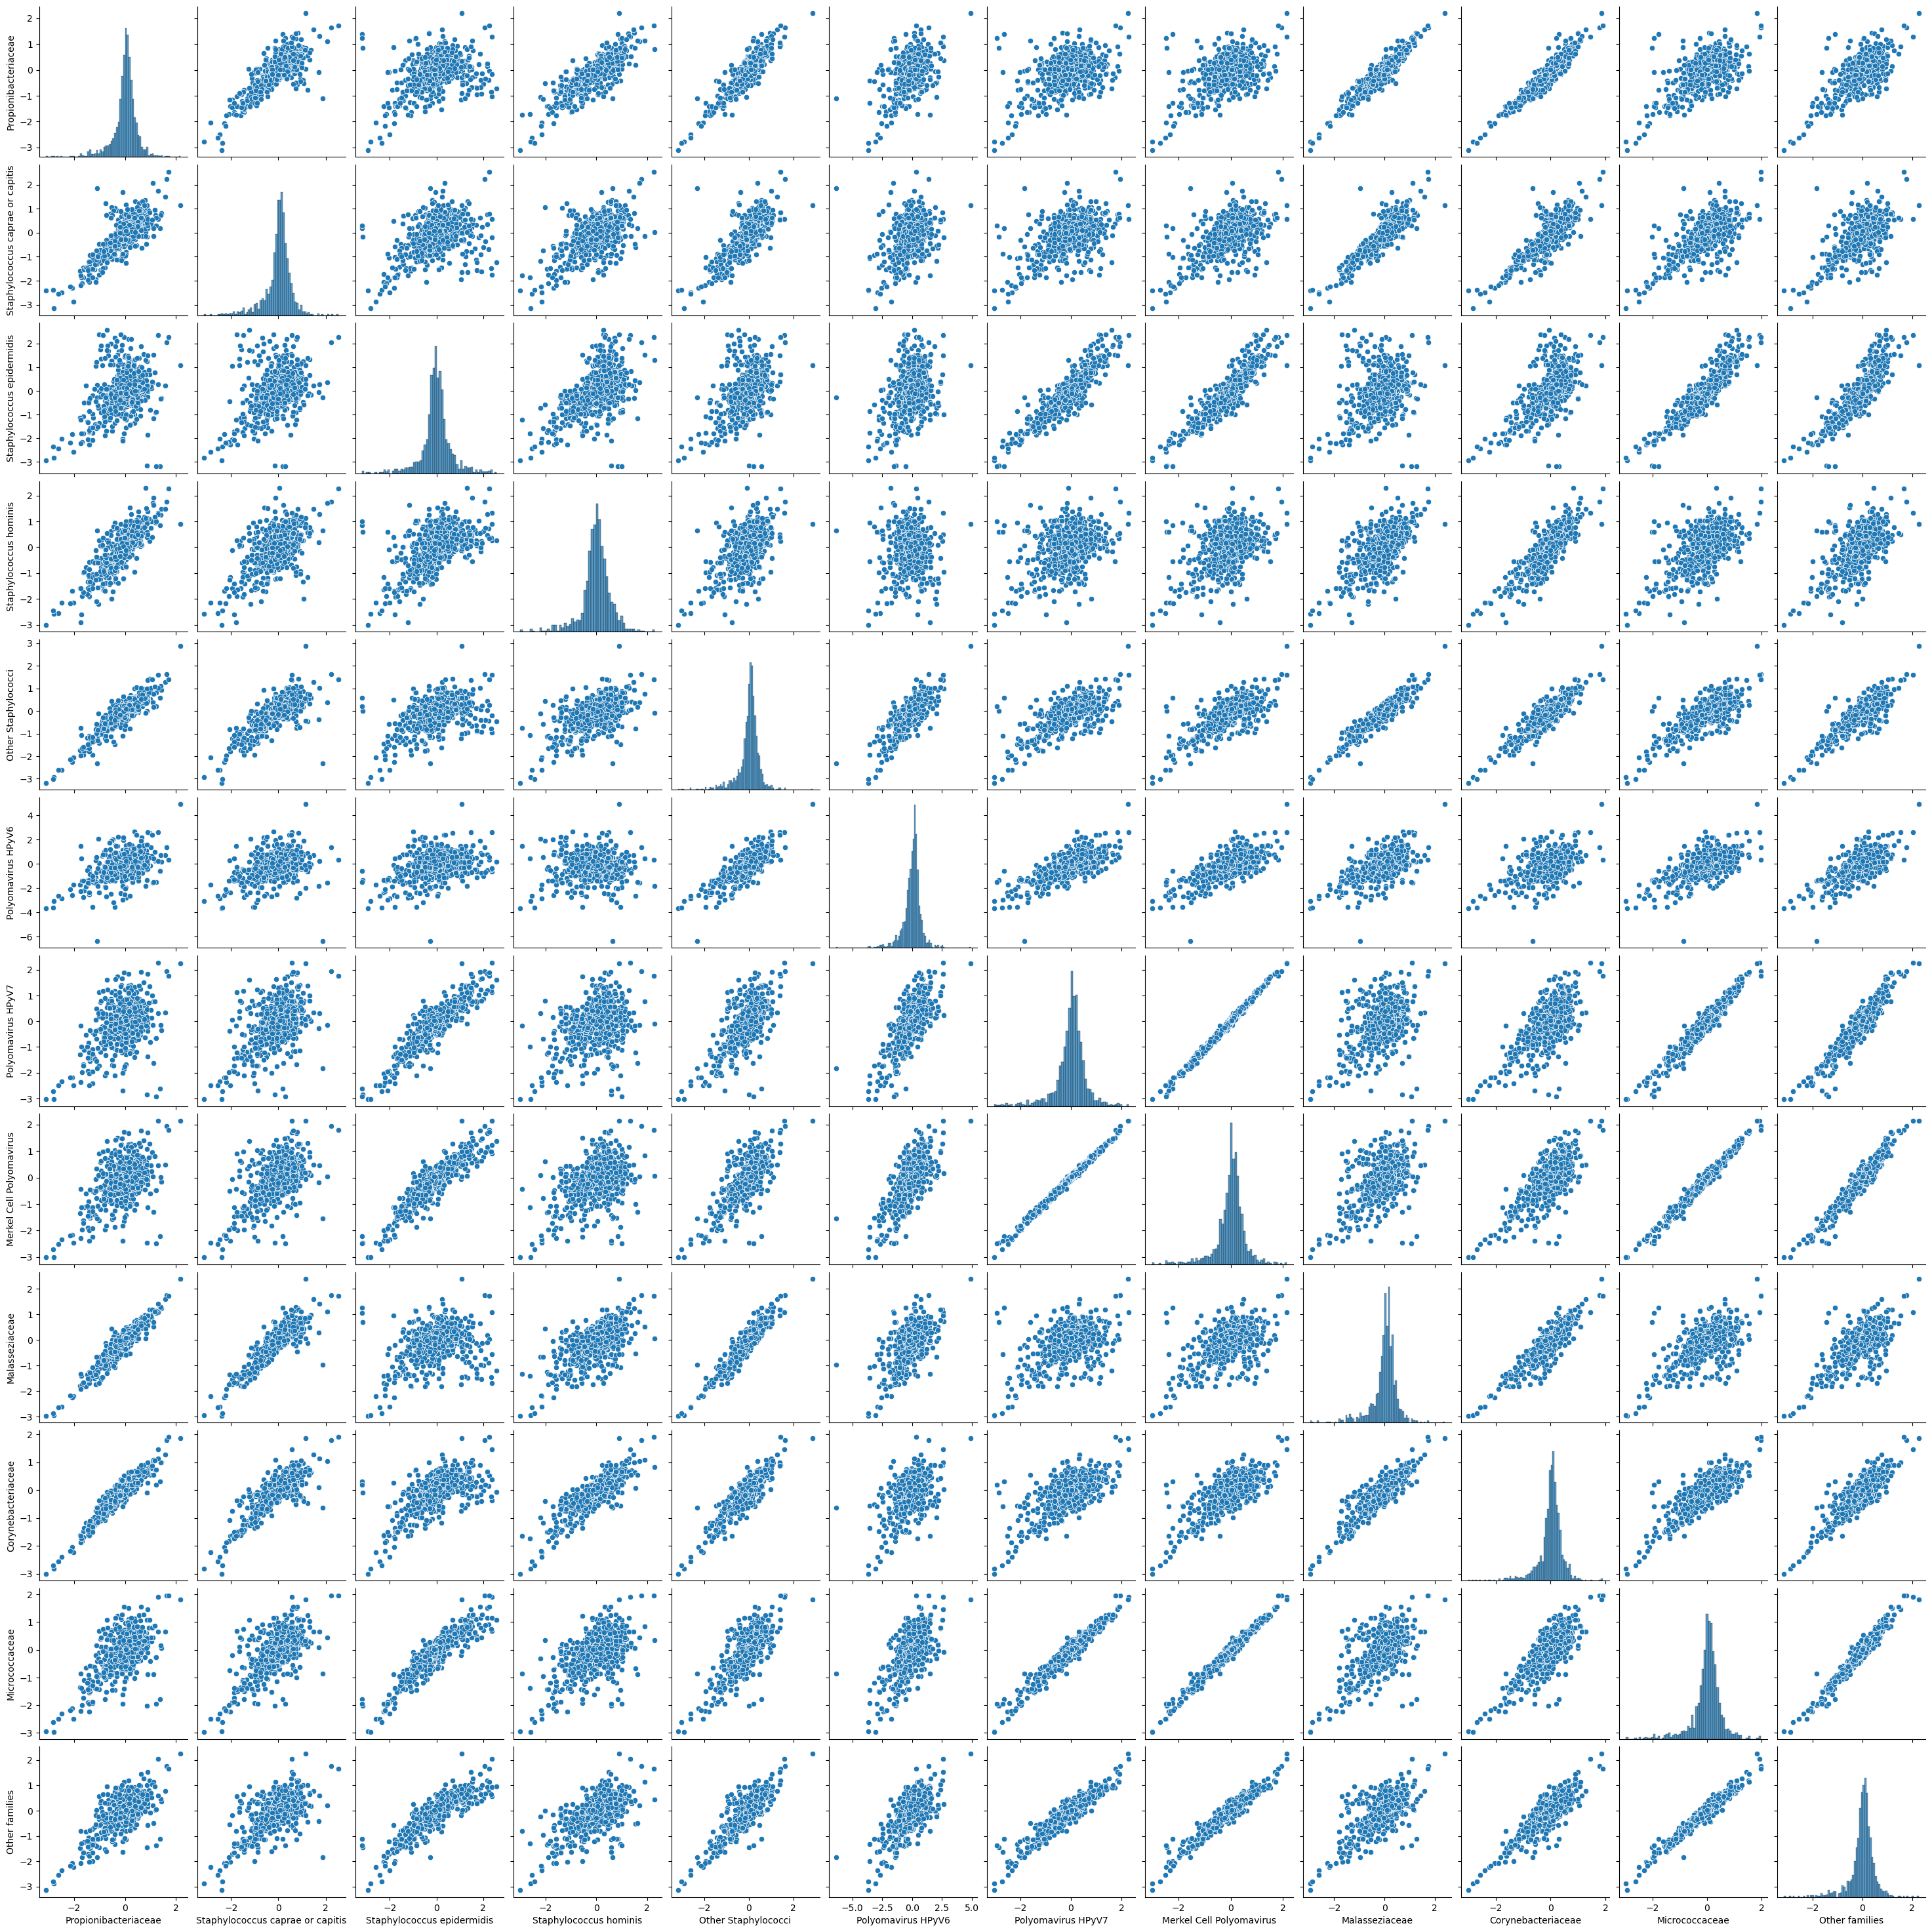

In [34]:
sns.pairplot(table)

The local density of this plot could be calculated with np.histogram:
https://stackoverflow.com/questions/33967513/creating-density-estimate-in-numpy
https://stackoverflow.com/questions/9141732/how-does-numpy-histogram-work

Because the data is m-dimensional (m = # microbes), we need np.histogramdd:
https://numpy.org/doc/stable/reference/generated/numpy.histogramdd.html

Alternatively, one could use an m-dimensional (m = # microbes) Hotelling ellipsoid at 95% cutoff:
https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
https://carstenschelp.github.io/2018/09/14/Plot_Confidence_Ellipse_001.html

# Transform data

Transform into wide format and rank the results:

In [35]:
longform_pairwise = table.unstack().to_frame('interactionLogCondProb')
longform_pairwise['interactionLogCondProb_abs'] = abs(longform_pairwise['interactionLogCondProb'])
longform_pairwise['interactionLogCondProb_sign'] = np.where(longform_pairwise['interactionLogCondProb'] > 0, 
                                                                 'positive', 'negative')
longform_pairwise.sort_values('interactionLogCondProb_abs', ascending=False, inplace=True)
longform_pairwise.reset_index(inplace=True)
longform_pairwise.reset_index(inplace=True)
longform_pairwise.head()

,index,level_0,featureid,interactionLogCondProb,interactionLogCondProb_abs,interactionLogCondProb_sign
0,0,Polyomavirus HPyV6,X961243,-6.375588,6.375588,negative
1,1,Polyomavirus HPyV6,X970121,4.898544,4.898544,positive
2,2,Polyomavirus HPyV6,X940071,-3.667902,3.667902,negative
3,3,Polyomavirus HPyV6,X960683,-3.646520,3.646520,negative
4,4,Polyomavirus HPyV6,X940239,-3.584330,3.584330,negative


# Graph

In [36]:
G = nx.Graph()
G = nx.from_pandas_edgelist(longform_pairwise, 'level_0', 'featureid',
                            edge_attr=['index', 'interactionLogCondProb', 'interactionLogCondProb_abs', 'interactionLogCondProb_sign'])
nx.info(G)

/tmp/ipykernel_1186/2291082867.py:4: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(G)


'Graph with 1237 nodes and 14700 edges'

Add node_type as node attribute

In [37]:
microbe_metadata = pd.DataFrame(index = table.columns.values)
microbe_metadata['node_type'] = 'microbe' 
microbe_metadata.head()

,node_type
Propionibacteriaceae,microbe
Staphylococcus caprae or capitis,microbe
Staphylococcus epidermidis,microbe
Staphylococcus hominis,microbe
Other Staphylococci,microbe


In [38]:
metabolite_metadata = pd.DataFrame(index = table.index.values)
metabolite_metadata['node_type'] = 'metabolite' 
metabolite_metadata.head()

,node_type
X940001,metabolite
X940002,metabolite
X940005,metabolite
X940007,metabolite
X940010,metabolite


In [39]:
nx.set_node_attributes(G, microbe_metadata.T.to_dict())
nx.set_node_attributes(G, metabolite_metadata.T.to_dict())

In [40]:
nx.write_graphml(G, results_folder + '/' + results_base_name + '_graph.graphml')